# xG값 재현하기

## 분석 목적/ 인사이트

### 분석 목적

- 슛 이벤트 데이터를 활용해“슛이 골로 이어질 확률(xG)”을 직접 예측하는 모델을 구축
- Target: result → is_goal (0/1)
- Understat에서 제공하는 xG와 직접 만든 xG를 비교,평가
    - Understat의 xG값을 정답값으로 사용 예정
- 제공되는 xG값이 있는데 다시 예측하는 이유
    - 실제 산업에서 쓰이는 모델 재현
    - 변수 영향력 확인

### 기대 인사이트

####  모델링 성능 비교
- 모델이 Understat xG와 얼마나 유사하게 작동하는가?
- 특정 상황(예: 페널티킥, 장거리슛)에서 Understat의 차이가 두드러지는가?

#### 모델 해석력
- 어떤 변수가 골 확률에 가장 크게 영향을 미치는지 확인 (예: 슛 거리, 각도, 슛 타입, 상황)

#### 선수별 분석
- 어떤 선수가 xG값 대비 goal이 많을지 파악

## 데이터불러오기

In [ ]:
# https://understat.com/
# Understats 사이트의 비공식 API wrapper 설치
# 상업적 사용 제외 가능
!pip install understat aiohttp 

참고 사이트: https://github.com/amosbastian/understat

In [49]:
import asyncio, aiohttp, pandas as pd
from understat import Understat

LEAGUE = "epl"
SEASON = 2024   # 2024/25 시즌

async def fetch_match_ids(league, season):
    async with aiohttp.ClientSession() as sess:
        us = Understat(sess)
        results = await us.get_league_results(league, season) # 리그, 시즌에 해당하는 모든 JSON을 가져옴
        match_ids = [int(r["id"]) for r in results] # 경기 ID 별로 정리
        return results, match_ids

results, match_ids = await fetch_match_ids(LEAGUE, SEASON)
print(len(match_ids))      # 경기 수(20팀이 Home/Away로 각 팀과 두번씩 경기를 진행)
pd.DataFrame(results).head()

380


,id,isResult,h,a,goals,xG,datetime,forecast
0,26602,True,"{'id': '89', 'title': 'Manchester United', 'sh...","{'id': '228', 'title': 'Fulham', 'short_title'...","{'h': '1', 'a': '0'}","{'h': '2.04268', 'a': '0.418711'}",2024-08-16 19:00:00,"{'w': '0.8069', 'd': '0.1489', 'l': '0.0442'}"
1,26603,True,"{'id': '285', 'title': 'Ipswich', 'short_title...","{'id': '87', 'title': 'Liverpool', 'short_titl...","{'h': '0', 'a': '2'}","{'h': '0.342601', 'a': '3.92906'}",2024-08-17 11:30:00,"{'w': '0.0026', 'd': '0.018', 'l': '0.9794'}"
2,26604,True,"{'id': '83', 'title': 'Arsenal', 'short_title'...","{'id': '229', 'title': 'Wolverhampton Wanderer...","{'h': '2', 'a': '0'}","{'h': '1.6283', 'a': '0.575835'}",2024-08-17 14:00:00,"{'w': '0.6528', 'd': '0.231', 'l': '0.1162'}"
3,26605,True,"{'id': '72', 'title': 'Everton', 'short_title'...","{'id': '220', 'title': 'Brighton', 'short_titl...","{'h': '0', 'a': '3'}","{'h': '0.405325', 'a': '1.79083'}",2024-08-17 14:00:00,"{'w': '0.0481', 'd': '0.1635', 'l': '0.7884'}"
4,26606,True,"{'id': '86', 'title': 'Newcastle United', 'sho...","{'id': '74', 'title': 'Southampton', 'short_ti...","{'h': '1', 'a': '0'}","{'h': '0.433489', 'a': '1.95483'}",2024-08-17 14:00:00,"{'w': '0.0378', 'd': '0.164', 'l': '0.7982'}"


In [50]:
async def fetch_shots_for_matches(match_ids, concurrency=8): # 동시에 최대 8개의 요청만 보내도록 제한(과부화 방지)
    sem = asyncio.Semaphore(concurrency)
    shots_all = []
    async with aiohttp.ClientSession() as sess:
        us = Understat(sess)

        async def fetch_one(mid):
            async with sem:
                d = await us.get_match_shots(mid)
                for side in ("h","a"): # Home/Away로 구분
                    for s in d.get(side, []):
                        s["side"] = side
                        s["match_id"] = mid
                        shots_all.append(s)

        await asyncio.gather(*(fetch_one(m) for m in match_ids))
    return shots_all

shots = await fetch_shots_for_matches(match_ids, concurrency=8)
shots_df = pd.DataFrame(shots)
shots_df.to_csv("epl2024_shots.csv", index=False)
shots_df.head()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,...,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction,side
0,584630,19,MissedShots,0.970999984741211,0.6730000305175782,0.050078392028808594,Bruno Fernandes,h,1228,OpenPlay,...,LeftFoot,26602,Manchester United,Fulham,1,0,2024-08-16 19:00:00,Lisandro Martínez,Chipped,h
1,584631,26,MissedShots,0.7469999694824219,0.47900001525878905,0.020807035267353058,Casemiro,h,2248,OpenPlay,...,RightFoot,26602,Manchester United,Fulham,1,0,2024-08-16 19:00:00,Mason Mount,Pass,h
2,584632,28,SavedShot,0.9130000305175782,0.34599998474121096,0.25769174098968506,Bruno Fernandes,h,1228,OpenPlay,...,RightFoot,26602,Manchester United,Fulham,1,0,2024-08-16 19:00:00,Casemiro,Pass,h
3,584633,33,SavedShot,0.9130000305175782,0.46299999237060546,0.4701629877090454,Bruno Fernandes,h,1228,OpenPlay,...,RightFoot,26602,Manchester United,Fulham,1,0,2024-08-16 19:00:00,Casemiro,Pass,h
4,584634,36,MissedShots,0.9580000305175781,0.5990000152587891,0.01805894263088703,Casemiro,h,2248,FromCorner,...,Head,26602,Manchester United,Fulham,1,0,2024-08-16 19:00:00,Amad Diallo Traore,Aerial,h


In [51]:
shots_df.tail()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,...,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction,side
9873,636431,53,MissedShots,0.9630000305175781,0.46799999237060547,0.13503046333789825,Manuel Akanji,a,6490,FromCorner,...,Head,26981,Fulham,Manchester City,0,2,2025-05-25 15:00:00,Bernardo Silva,Cross,a
9874,636432,54,BlockedShot,0.785,0.6320000076293946,0.0354330837726593,Erling Haaland,a,8260,OpenPlay,...,LeftFoot,26981,Fulham,Manchester City,0,2,2025-05-25 15:00:00,Bernardo Silva,Pass,a
9875,636433,59,MissedShots,0.9580000305175781,0.5740000152587891,0.06427739560604095,Erling Haaland,a,8260,SetPiece,...,Head,26981,Fulham,Manchester City,0,2,2025-05-25 15:00:00,None,Aerial,a
9876,636435,71,Goal,0.885,0.5,0.7611688375473022,Erling Haaland,a,8260,Penalty,...,LeftFoot,26981,Fulham,Manchester City,0,2,2025-05-25 15:00:00,None,Standard,a
9877,636436,75,MissedShots,0.8980000305175782,0.29700000762939455,0.060841310769319534,Erling Haaland,a,8260,OpenPlay,...,LeftFoot,26981,Fulham,Manchester City,0,2,2025-05-25 15:00:00,Matheus Nunes,Pass,a


## 데이터 확인

In [52]:
shots_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9878 entries, 0 to 9877
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               9878 non-null   object
 1   minute           9878 non-null   object
 2   result           9878 non-null   object
 3   X                9878 non-null   object
 4   Y                9878 non-null   object
 5   xG               9878 non-null   object
 6   player           9878 non-null   object
 7   h_a              9878 non-null   object
 8   player_id        9878 non-null   object
 9   situation        9878 non-null   object
 10  season           9878 non-null   object
 11  shotType         9878 non-null   object
 12  match_id         9878 non-null   int64 
 13  h_team           9878 non-null   object
 14  a_team           9878 non-null   object
 15  h_goals          9878 non-null   object
 16  a_goals          9878 non-null   object
 17  date             9878 non-null   

In [53]:
# player_assisted의 결측값은 어시스트한 선수가 없을 때 Null값을 가짐
# minute, X, Y, xG, h_goals, a_goals 등은 수치형 데이터이지만 object로 나와있는 것을 확인할 수 있음

In [54]:
shots_df.nunique()

id                 9878
minute              104
result                6
X                   380
Y                   584
xG                 9761
player              458
h_a                   2
player_id           458
situation             5
season                1
shotType              4
match_id            380
h_team               20
a_team               20
h_goals               7
a_goals               7
date                216
player_assisted     460
lastAction           31
side                  2
dtype: int64

In [55]:
shots_df['result'].unique()

array(['MissedShots', 'SavedShot', 'BlockedShot', 'Goal', 'ShotOnPost',
       'OwnGoal'], dtype=object)

In [56]:
shots_df['situation'].unique()

array(['OpenPlay', 'FromCorner', 'SetPiece', 'DirectFreekick', 'Penalty'],
      dtype=object)

In [57]:
shots_df['shotType'].unique()

array(['LeftFoot', 'RightFoot', 'Head', 'OtherBodyPart'], dtype=object)

In [58]:
shots_df['lastAction'].unique()

array(['Chipped', 'Pass', 'Aerial', 'TakeOn', 'None', 'BallRecovery',
       'Cross', 'BallTouch', 'Rebound', 'Standard', 'Dispossessed',
       'HeadPass', 'LayOff', 'Throughball', 'Tackle', 'Foul',
       'CornerAwarded', 'Goal', 'Save', 'Card', 'Interception',
       'Challenge', 'OffsidePass', 'BlockedPass', 'OffsideProvoked',
       'End', 'Clearance', 'ShieldBallOpp', 'ChanceMissed',
       'FormationChange', 'KeeperPickup'], dtype=object)

In [59]:
# id: 슛 이벤트 고유 id
# minute: 슛이 발생한 시간
# result: 슛 결과
# X,Y: 슛이 발생한 경기장 내의 좌표
# xG: 기대 득점
# player: 선수명
# h_a: Home/away
# player_id: 선수 고유 ID
# situation: 슛상황(OpenPlay/ Penalty, FromCorner, SetPiece, DirectFreekick)
# season: 시즌 연도
# shotType: 슛 종류(RightFoot/ LeftFoot/ Head/ OtherBodyPart)
# match_id: 경기 고유 ID
# h_team: 홈 팀명
# a_team: 어웨이 팀명
# h_goals: 홈 팀 최종 득점 수
# a_goals: 어웨이 팀 최종 득점 수
# date: 날짜(년-월-일 시-분-초)
# player_assisted : 어시스트한 선수(없으면 결측)
# lastAction: 슛 직전 일어난 액션
# side: 홈/원정 여부 (h_a랑 중복)

In [60]:
shots_df.describe()

,match_id
count,9878.000000
mean,26788.936931
std,109.720566
min,26602.000000
25%,26693.000000
50%,26787.000000
75%,26884.000000
max,26981.000000


In [61]:
shots_df.describe(include='all')

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,...,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction,side
count,9878,9878,9878,9878,9878,9878,9878,9878,9878,9878,...,9878,9878.000000,9878,9878,9878,9878,9878,7377,9878,9878
unique,9878,104,6,380,584,9761,458,2,458,5,...,4,NaN,20,20,7,7,216,460,31,2
top,584630,46,MissedShots,0.885,0.5,0.7611688375473022,Mohamed Salah,h,1250,OpenPlay,...,RightFoot,NaN,Brentford,West Ham,1,1,2025-05-25 15:00:00,Bruno Fernandes,Pass,h
freq,1,179,3346,121,118,83,130,5230,130,7318,...,4819,NaN,551,566,3068,3479,268,92,3764,5230
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,26788.936931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,109.720566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,26602.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,26693.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,26787.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,26884.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
# object형태로 표시된 수치형 데이터를 변환 후 다시 확인

# 변환할 컬럼 목록
int_cols = ["minute", "h_goals", "a_goals"]
float_cols = ["X", "Y", "xG"]

shots_df[int_cols] = shots_df[int_cols].apply(pd.to_numeric, errors="coerce").astype("Int64")
shots_df[float_cols] = shots_df[float_cols].apply(pd.to_numeric, errors="coerce").astype(float)

shots_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9878 entries, 0 to 9877
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               9878 non-null   object 
 1   minute           9878 non-null   Int64  
 2   result           9878 non-null   object 
 3   X                9878 non-null   float64
 4   Y                9878 non-null   float64
 5   xG               9878 non-null   float64
 6   player           9878 non-null   object 
 7   h_a              9878 non-null   object 
 8   player_id        9878 non-null   object 
 9   situation        9878 non-null   object 
 10  season           9878 non-null   object 
 11  shotType         9878 non-null   object 
 12  match_id         9878 non-null   int64  
 13  h_team           9878 non-null   object 
 14  a_team           9878 non-null   object 
 15  h_goals          9878 non-null   Int64  
 16  a_goals          9878 non-null   Int64  
 17  date          

In [63]:
shots_df.describe()

,minute,X,Y,xG,match_id,h_goals,a_goals
count,9878.0,9878.000000,9878.000000,9878.000000,9878.000000,9878.0,9878.0
mean,49.010427,0.858118,0.502775,0.125181,26788.936931,1.554667,1.464466
std,26.965631,0.086710,0.120866,0.167522,109.720566,1.283929,1.19417
min,0.0,0.006000,0.056000,0.000000,26602.000000,0.0,0.0
25%,26.0,0.808000,0.415000,0.031771,26693.000000,1.0,1.0
50%,49.0,0.872000,0.503000,0.059666,26787.000000,1.0,1.0
75%,71.0,0.915000,0.588000,0.110777,26884.000000,2.0,2.0
max,103.0,0.994000,0.995000,0.979322,26981.000000,7.0,6.0


In [64]:
shots_df.describe(include='all')

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,...,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction,side
count,9878,9878.0,9878,9878.000000,9878.000000,9878.000000,9878,9878,9878,9878,...,9878,9878.000000,9878,9878,9878.0,9878.0,9878,7377,9878,9878
unique,9878,<NA>,6,NaN,NaN,NaN,458,2,458,5,...,4,NaN,20,20,<NA>,<NA>,216,460,31,2
top,584630,<NA>,MissedShots,NaN,NaN,NaN,Mohamed Salah,h,1250,OpenPlay,...,RightFoot,NaN,Brentford,West Ham,<NA>,<NA>,2025-05-25 15:00:00,Bruno Fernandes,Pass,h
freq,1,<NA>,3346,NaN,NaN,NaN,130,5230,130,7318,...,4819,NaN,551,566,<NA>,<NA>,268,92,3764,5230
mean,NaN,49.010427,NaN,0.858118,0.502775,0.125181,NaN,NaN,NaN,NaN,...,NaN,26788.936931,NaN,NaN,1.554667,1.464466,NaN,NaN,NaN,NaN
std,NaN,26.965631,NaN,0.086710,0.120866,0.167522,NaN,NaN,NaN,NaN,...,NaN,109.720566,NaN,NaN,1.283929,1.19417,NaN,NaN,NaN,NaN
min,NaN,0.0,NaN,0.006000,0.056000,0.000000,NaN,NaN,NaN,NaN,...,NaN,26602.000000,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
25%,NaN,26.0,NaN,0.808000,0.415000,0.031771,NaN,NaN,NaN,NaN,...,NaN,26693.000000,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
50%,NaN,49.0,NaN,0.872000,0.503000,0.059666,NaN,NaN,NaN,NaN,...,NaN,26787.000000,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
75%,NaN,71.0,NaN,0.915000,0.588000,0.110777,NaN,NaN,NaN,NaN,...,NaN,26884.000000,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN


## EDA

In [65]:
shots_df['is_goal']=(shots_df['result'] == "Goal").astype(int)
shots_df['is_goal'].value_counts(normalize=True)

0    0.890565
1    0.109435
Name: is_goal, dtype: float64

전체 슈팅 중 노골이 약 89%

In [66]:
print(shots_df['situation'].value_counts())

OpenPlay          7318
FromCorner        1619
SetPiece           589
DirectFreekick     269
Penalty             83
Name: situation, dtype: int64


In [67]:
print(shots_df['shotType'].value_counts())

RightFoot        4819
LeftFoot         3288
Head             1729
OtherBodyPart      42
Name: shotType, dtype: int64


In [68]:
print(shots_df['lastAction'].value_counts())

Pass               3764
Cross              1310
None               1134
Aerial              807
Rebound             501
TakeOn              456
Chipped             417
Standard            352
BallRecovery        261
Throughball         231
BallTouch           228
HeadPass            187
Dispossessed         53
LayOff               45
Foul                 27
Tackle               24
CornerAwarded        18
BlockedPass          15
Interception          7
End                   7
Goal                  6
Save                  5
Clearance             5
Challenge             4
OffsidePass           4
Card                  3
OffsideProvoked       2
FormationChange       2
ShieldBallOpp         1
ChanceMissed          1
KeeperPickup          1
Name: lastAction, dtype: int64


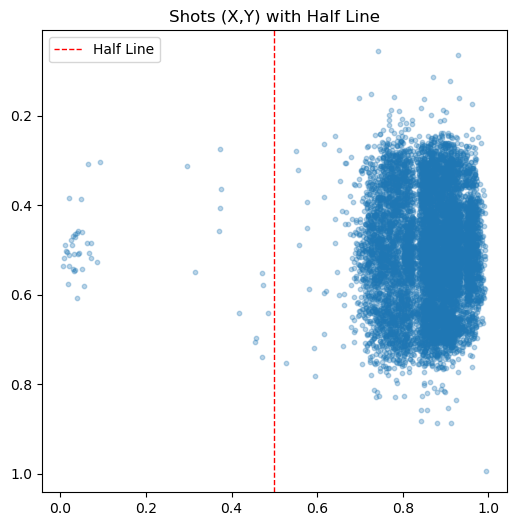

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(shots_df['X'].astype(float), shots_df['Y'].astype(float), alpha=0.3, s=10)

# 하프라인 (X=0.5)
plt.axvline(0.5, color='red', linestyle='--', linewidth=1, label='Half Line')

# 좌표계 뒤집기 (Understat Y축 방향 맞춤)
plt.gca().invert_yaxis()

plt.title("Shots (X,Y) with Half Line")
plt.legend()
plt.show()

X=0 -> 자기 진영,  X=1 -> 상대진영

Y=0 -> 왼쪽, Y=1 -> 오른쪽

(0.5,0.5) -> 센터 스팟

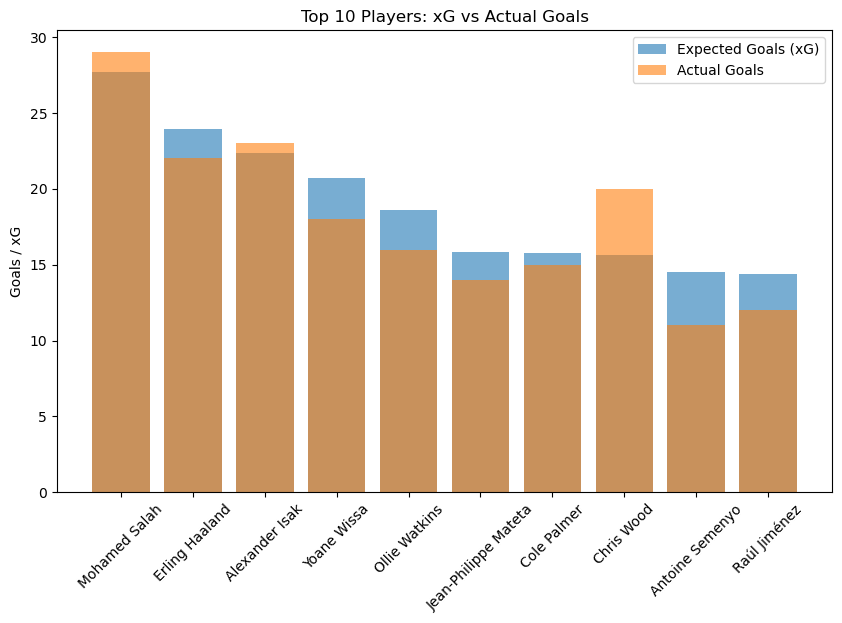

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

player_stats = shots_df.groupby('player').agg(
    total_xG=('xG', 'sum'),
    goals=('result', lambda x: (x == 'Goal').sum()),
    shots=('xG', 'count')
).reset_index()

# xG vs Goals barplot
top_players = player_stats.sort_values('total_xG', ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.bar(top_players['player'], top_players['total_xG'], label='Expected Goals (xG)', alpha=0.6)
plt.bar(top_players['player'], top_players['goals'], label='Actual Goals', alpha=0.6)
plt.xticks(rotation=45)
plt.ylabel("Goals / xG")
plt.title("Top 10 Players: xG vs Actual Goals")
plt.legend()
plt.show()

득점 상위 10명의 선수 중 xG값보다 실제 골이 많은 선수는 살라, 이삭, 우드 선수

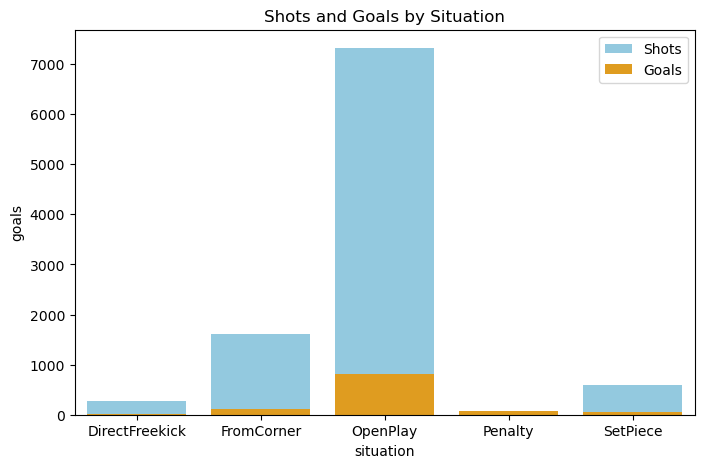

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# situation 별 슛 수와 골 수
situation_stats = shots_df.groupby('situation').agg(
    shots=('id','count'),
    goals=('result', lambda x: (x == 'Goal').sum())
).reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=situation_stats, x='situation', y='shots', color='skyblue', label='Shots')
sns.barplot(data=situation_stats, x='situation', y='goals', color='orange', label='Goals')
plt.title("Shots and Goals by Situation")
plt.legend()
plt.show()

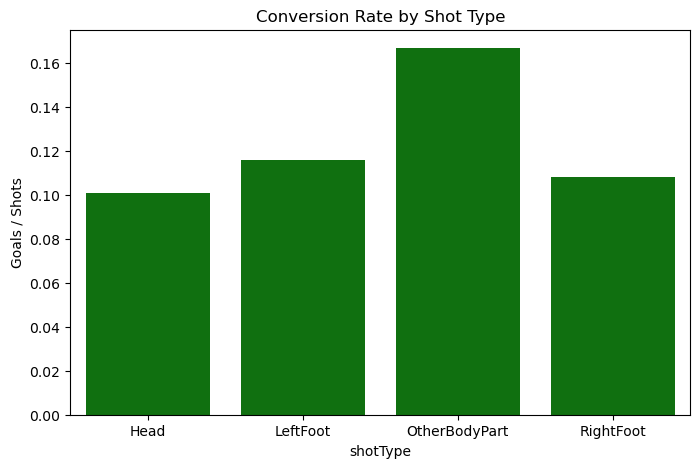

In [72]:
# shotType 별 성공률
shottype_stats = shots_df.groupby('shotType').agg(
    shots=('id','count'),
    goals=('result', lambda x: (x == 'Goal').sum())
).reset_index()
shottype_stats['conversion_rate'] = shottype_stats['goals'] / shottype_stats['shots']

plt.figure(figsize=(8,5))
sns.barplot(data=shottype_stats, x='shotType', y='conversion_rate', color='green')
plt.title("Conversion Rate by Shot Type")
plt.ylabel("Goals / Shots")
plt.show()

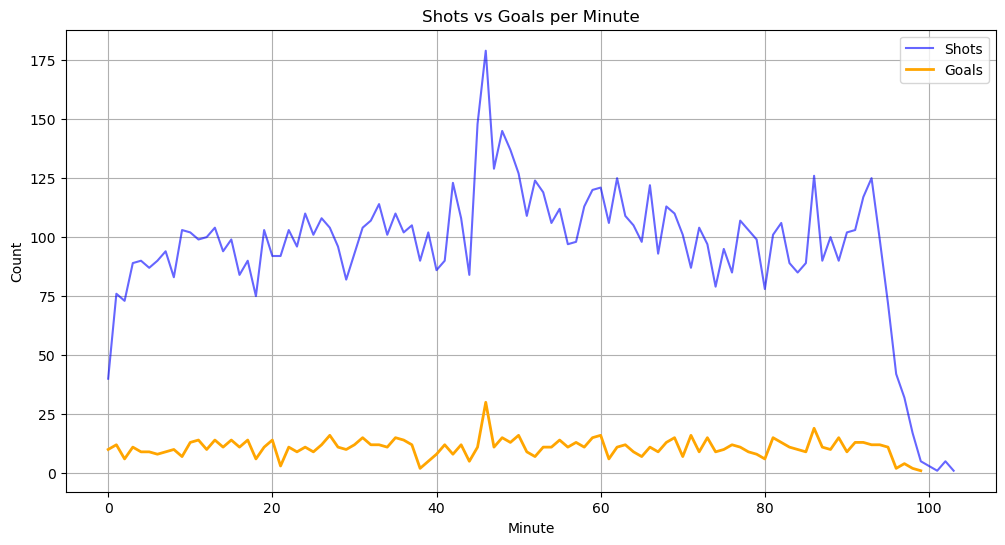

In [73]:
# 슛
minute_counts = shots_df.groupby('minute').size()
# 골
goals_df = shots_df[shots_df['result'] == 'Goal']
goal_counts = goals_df.groupby('minute').size()

plt.figure(figsize=(12,6))
plt.plot(minute_counts.index, minute_counts.values, label='Shots', color='blue', alpha=0.6)
plt.plot(goal_counts.index, goal_counts.values, label='Goals', color='orange', linewidth=2)
plt.title("Shots vs Goals per Minute")
plt.xlabel("Minute")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()

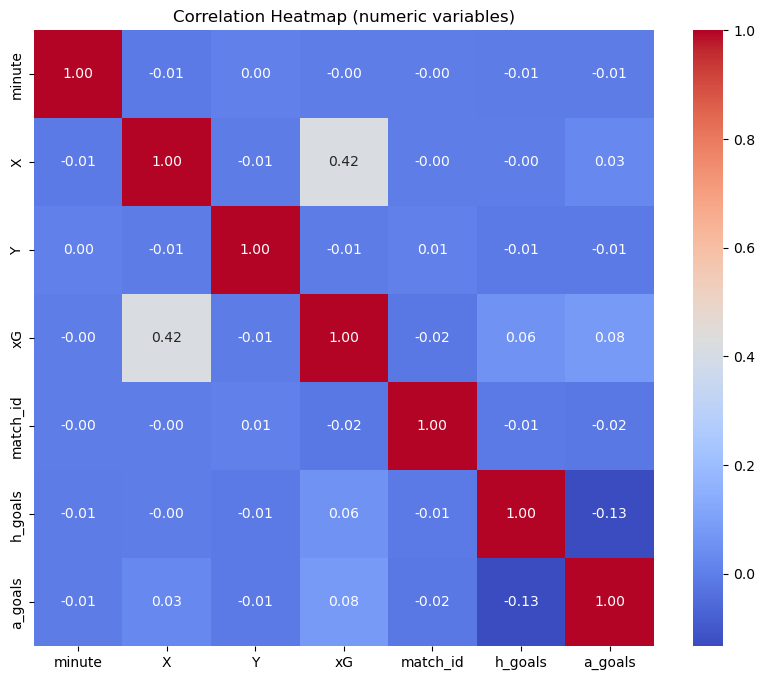

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# 숫자형 컬럼만 선택
numeric_cols = shots_df.select_dtypes(include=['float64','int64'])

plt.figure(figsize=(10,8))
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (numeric variables)")
plt.show()

- 상대 골대에 가까울수록(X 좌표↑) xG가 높아지는 경향이 있음
- Y도 중앙에 가까울 수록 상관관계가 높다고 생각했지만 상관관계가 낮음(비선형관계?)
- h_goals와 a_goals가 약한 상관관계가 존재하는 이유는 한 팀이 많이 넣으면 한 팀은 적게 넣을 가능성이 있음(약한 음의 상관관계)

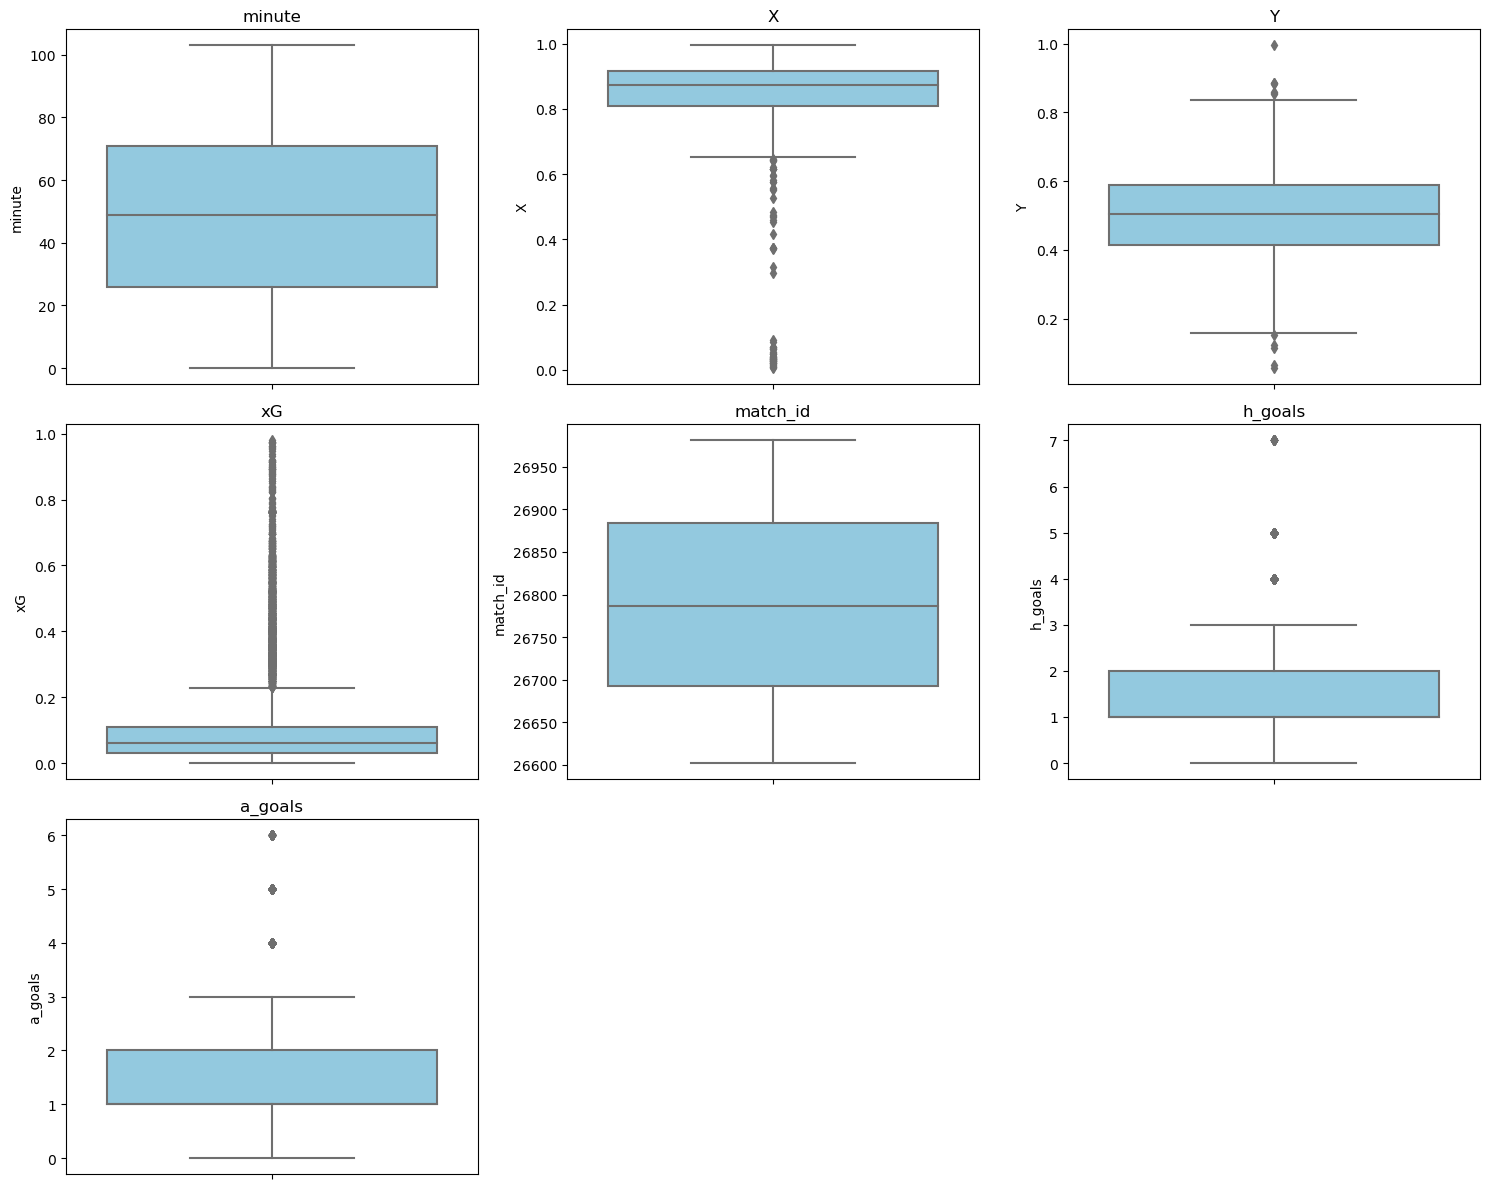

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# 수치형 컬럼만 선택
numeric_cols = shots_df.select_dtypes(include=['float64','int64']).columns

# 서브플롯 크기 설정
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols*5, n_rows*4))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(y=shots_df[col], color='skyblue')
    plt.title(col)

plt.tight_layout()
plt.show()

이상치는 존재하지만, 실제 축구 경기에서 나올 수 있는 결과이기에 최대, 최소값을 확인 후 범위가 벗어나지 않는다면 처리x

In [76]:
print('minute: ', shots_df['minute'].min(), shots_df['minute'].max())
print('X: ', shots_df['X'].min(), shots_df['X'].max())
print('Y: ', shots_df['Y'].min(), shots_df['Y'].max())
print('xG: ', shots_df['xG'].min(), shots_df['xG'].max())
print('h_goals: ', shots_df['h_goals'].min(), shots_df['h_goals'].max())
print('a_goals: ', shots_df['a_goals'].min(), shots_df['a_goals'].max())

minute:  0 103
X:  0.0060000002384185 0.9940000152587892
Y:  0.0559999990463256 0.995
xG:  0.0 0.9793221354484558
h_goals:  0 7
a_goals:  0 6


리그의 경우 연장전이 없어 최대 90분이지만, 추가시간을 고려하면 103분이 가능하다고 판단
- 2024년 8월 17일 에버튼 vs 브라이튼 에서 전반 4분, 후반 9분의 추가시간을 받음

2024년 8월 25일 울버햄튼(H) : 첼시(A) (2:6)

2025년 1월 20일 입스위치(H) : 맨체스터시티(A) (0:6)

2025년 2월 1일 노팅엄(H) : 브라이튼(A) (7:0)

최대, 최소 확인 이상없음

In [77]:
# FotMob의 경기 기록 확인

## 전처리
### 변수 제거

In [78]:
# h_a와 side 중복으로 제거
shots_df = shots_df.drop(columns=['side'])

In [79]:
shots_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9878 entries, 0 to 9877
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               9878 non-null   object 
 1   minute           9878 non-null   Int64  
 2   result           9878 non-null   object 
 3   X                9878 non-null   float64
 4   Y                9878 non-null   float64
 5   xG               9878 non-null   float64
 6   player           9878 non-null   object 
 7   h_a              9878 non-null   object 
 8   player_id        9878 non-null   object 
 9   situation        9878 non-null   object 
 10  season           9878 non-null   object 
 11  shotType         9878 non-null   object 
 12  match_id         9878 non-null   int64  
 13  h_team           9878 non-null   object 
 14  a_team           9878 non-null   object 
 15  h_goals          9878 non-null   Int64  
 16  a_goals          9878 non-null   Int64  
 17  date          

In [80]:
# result 으로 is_goal 변수 만들어 냈으니 제거
shots_df = shots_df.drop(columns=['result'])

### 파생변수 생성

In [81]:
import numpy as np

# 골대 중앙 좌표
goal_x, goal_y = 1.0, 0.5

# 슛 거리 계산
shots_df['shot_distance'] = np.sqrt((goal_x - shots_df['X'].astype(float))**2 + 
                                    (goal_y - shots_df['Y'].astype(float))**2)

# 확인
shots_df.head()

,id,minute,X,Y,xG,player,h_a,player_id,situation,season,...,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction,is_goal,shot_distance
0,584630,19,0.971,0.673,0.050078,Bruno Fernandes,h,1228,OpenPlay,2024,...,26602,Manchester United,Fulham,1,0,2024-08-16 19:00:00,Lisandro Martínez,Chipped,0,0.175414
1,584631,26,0.747,0.479,0.020807,Casemiro,h,2248,OpenPlay,2024,...,26602,Manchester United,Fulham,1,0,2024-08-16 19:00:00,Mason Mount,Pass,0,0.253870
2,584632,28,0.913,0.346,0.257692,Bruno Fernandes,h,1228,OpenPlay,2024,...,26602,Manchester United,Fulham,1,0,2024-08-16 19:00:00,Casemiro,Pass,0,0.176876
3,584633,33,0.913,0.463,0.470163,Bruno Fernandes,h,1228,OpenPlay,2024,...,26602,Manchester United,Fulham,1,0,2024-08-16 19:00:00,Casemiro,Pass,0,0.094541
4,584634,36,0.958,0.599,0.018059,Casemiro,h,2248,FromCorner,2024,...,26602,Manchester United,Fulham,1,0,2024-08-16 19:00:00,Amad Diallo Traore,Aerial,0,0.107541


#### 슛 각도

평균 경기장 크기 규정 : 105(M) * 68(M)

골대 크기 규정 : 7.32 (M) * 2.44(M)

- (7.32 / 68 ) / 2 = 약 0.054
- 골대 범위 0.446~0.554

In [82]:
def calculate_shot_angle(x, y, goal_y1=0.446, goal_y2=0.554, goal_x=1.0):
    # 포스트 벡터
    u = np.array([goal_x - x, goal_y1 - y])
    v = np.array([goal_x - x, goal_y2 - y])
    
    # 내적과 크기
    dot = np.dot(u, v)
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    
    # arccos으로 각도 계산
    angle = np.arccos(dot / (norm_u * norm_v))
    return angle  # 라디안 값 반환

# 데이터프레임 적용
shots_df['shot_angle'] = shots_df.apply(lambda row: calculate_shot_angle(float(row['X']), float(row['Y'])), axis=1)

# 확인
shots_df.head()

,id,minute,X,Y,xG,player,h_a,player_id,situation,season,...,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction,is_goal,shot_distance,shot_angle
0,584630,19,0.971,0.673,0.050078,Bruno Fernandes,h,1228,OpenPlay,2024,...,Manchester United,Fulham,1,0,2024-08-16 19:00:00,Lisandro Martínez,Chipped,0,0.175414,0.111973
1,584631,26,0.747,0.479,0.020807,Casemiro,h,2248,OpenPlay,2024,...,Manchester United,Fulham,1,0,2024-08-16 19:00:00,Mason Mount,Pass,0,0.253870,0.417893
2,584632,28,0.913,0.346,0.257692,Bruno Fernandes,h,1228,OpenPlay,2024,...,Manchester United,Fulham,1,0,2024-08-16 19:00:00,Casemiro,Pass,0,0.176876,0.319835
3,584633,33,0.913,0.463,0.470163,Bruno Fernandes,h,1228,OpenPlay,2024,...,Manchester United,Fulham,1,0,2024-08-16 19:00:00,Casemiro,Pass,0,0.094541,1.000837
4,584634,36,0.958,0.599,0.018059,Casemiro,h,2248,FromCorner,2024,...,Manchester United,Fulham,1,0,2024-08-16 19:00:00,Amad Diallo Traore,Aerial,0,0.107541,0.483018


In [83]:
shots_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9878 entries, 0 to 9877
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               9878 non-null   object 
 1   minute           9878 non-null   Int64  
 2   X                9878 non-null   float64
 3   Y                9878 non-null   float64
 4   xG               9878 non-null   float64
 5   player           9878 non-null   object 
 6   h_a              9878 non-null   object 
 7   player_id        9878 non-null   object 
 8   situation        9878 non-null   object 
 9   season           9878 non-null   object 
 10  shotType         9878 non-null   object 
 11  match_id         9878 non-null   int64  
 12  h_team           9878 non-null   object 
 13  a_team           9878 non-null   object 
 14  h_goals          9878 non-null   Int64  
 15  a_goals          9878 non-null   Int64  
 16  date             9878 non-null   object 
 17  player_assiste

#### 어시스트 결측값 처리

어시스트 유/무 변수도 같이 추가

In [84]:
shots_df['player_assisted'] = shots_df['player_assisted'].fillna("No Assist")
shots_df['assist_flag'] = shots_df['player_assisted'].apply(lambda x: 0 if x=="No Assist" else 1)

In [85]:
shots_df.tail()

,id,minute,X,Y,xG,player,h_a,player_id,situation,season,...,a_team,h_goals,a_goals,date,player_assisted,lastAction,is_goal,shot_distance,shot_angle,assist_flag
9873,636431,53,0.963,0.468,0.135030,Manuel Akanji,a,6490,FromCorner,2024,...,Manchester City,0,2,2025-05-25 15:00:00,Bernardo Silva,Cross,0,0.048918,1.700938,1
9874,636432,54,0.785,0.632,0.035433,Erling Haaland,a,8260,OpenPlay,2024,...,Manchester City,0,2,2025-05-25 15:00:00,Bernardo Silva,Pass,0,0.252288,0.365181,1
9875,636433,59,0.958,0.574,0.064277,Erling Haaland,a,8260,SetPiece,2024,...,Manchester City,0,2,2025-05-25 15:00:00,No Assist,Aerial,0,0.085088,0.809321,0
9876,636435,71,0.885,0.500,0.761169,Erling Haaland,a,8260,Penalty,2024,...,Manchester City,0,2,2025-05-25 15:00:00,No Assist,Standard,1,0.115000,0.878009,0
9877,636436,75,0.898,0.297,0.060841,Erling Haaland,a,8260,OpenPlay,2024,...,Manchester City,0,2,2025-05-25 15:00:00,Matheus Nunes,Pass,0,0.227185,0.222471,1


### 인코딩

In [86]:
# h=홈(1), a=원정(0) 으로 인코딩
shots_df['home_away'] = shots_df['h_a'].map({'h': 1, 'a': 0})

# 기존 h_a 컬럼 제거
shots_df = shots_df.drop(columns=['h_a'])

shots_df.tail()

,id,minute,X,Y,xG,player,player_id,situation,season,shotType,...,h_goals,a_goals,date,player_assisted,lastAction,is_goal,shot_distance,shot_angle,assist_flag,home_away
9873,636431,53,0.963,0.468,0.135030,Manuel Akanji,6490,FromCorner,2024,Head,...,0,2,2025-05-25 15:00:00,Bernardo Silva,Cross,0,0.048918,1.700938,1,0
9874,636432,54,0.785,0.632,0.035433,Erling Haaland,8260,OpenPlay,2024,LeftFoot,...,0,2,2025-05-25 15:00:00,Bernardo Silva,Pass,0,0.252288,0.365181,1,0
9875,636433,59,0.958,0.574,0.064277,Erling Haaland,8260,SetPiece,2024,Head,...,0,2,2025-05-25 15:00:00,No Assist,Aerial,0,0.085088,0.809321,0,0
9876,636435,71,0.885,0.500,0.761169,Erling Haaland,8260,Penalty,2024,LeftFoot,...,0,2,2025-05-25 15:00:00,No Assist,Standard,1,0.115000,0.878009,0,0
9877,636436,75,0.898,0.297,0.060841,Erling Haaland,8260,OpenPlay,2024,LeftFoot,...,0,2,2025-05-25 15:00:00,Matheus Nunes,Pass,0,0.227185,0.222471,1,0


In [87]:
# 원핫 인코딩 대상
categorical_cols = ['situation', 'shotType']

# 원핫 인코딩 수행 (drop_first=True → 다중공선성 방지)
shots_df = pd.get_dummies(shots_df, 
                          columns=categorical_cols, 
                          drop_first=True)

# 결과 확인
print(shots_df.head())
print("현재 컬럼 개수:", shots_df.shape[1])

       id  minute      X      Y        xG           player player_id season  \
0  584630      19  0.971  0.673  0.050078  Bruno Fernandes      1228   2024   
1  584631      26  0.747  0.479  0.020807         Casemiro      2248   2024   
2  584632      28  0.913  0.346  0.257692  Bruno Fernandes      1228   2024   
3  584633      33  0.913  0.463  0.470163  Bruno Fernandes      1228   2024   
4  584634      36  0.958  0.599  0.018059         Casemiro      2248   2024   

   match_id             h_team  ... shot_angle  assist_flag  home_away  \
0     26602  Manchester United  ...   0.111973            1          1   
1     26602  Manchester United  ...   0.417893            1          1   
2     26602  Manchester United  ...   0.319835            1          1   
3     26602  Manchester United  ...   1.000837            1          1   
4     26602  Manchester United  ...   0.483018            1          1   

  situation_FromCorner situation_OpenPlay situation_Penalty  \
0                

In [88]:
shots_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9878 entries, 0 to 9877
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      9878 non-null   object 
 1   minute                  9878 non-null   Int64  
 2   X                       9878 non-null   float64
 3   Y                       9878 non-null   float64
 4   xG                      9878 non-null   float64
 5   player                  9878 non-null   object 
 6   player_id               9878 non-null   object 
 7   season                  9878 non-null   object 
 8   match_id                9878 non-null   int64  
 9   h_team                  9878 non-null   object 
 10  a_team                  9878 non-null   object 
 11  h_goals                 9878 non-null   Int64  
 12  a_goals                 9878 non-null   Int64  
 13  date                    9878 non-null   object 
 14  player_assisted         9878 non-null   

#### lastAction 인코딩

범주가 많아 Target encoding

In [89]:
# lastAction별 골 확률 계산
goal_rate = shots_df.groupby('lastAction')['is_goal'].mean()

# 매핑하여 새로운 컬럼 생성
shots_df['lastAction_encoded'] = shots_df['lastAction'].map(goal_rate)

In [90]:
shots_df.head()

,id,minute,X,Y,xG,player,player_id,season,match_id,h_team,...,assist_flag,home_away,situation_FromCorner,situation_OpenPlay,situation_Penalty,situation_SetPiece,shotType_LeftFoot,shotType_OtherBodyPart,shotType_RightFoot,lastAction_encoded
0,584630,19,0.971,0.673,0.050078,Bruno Fernandes,1228,2024,26602,Manchester United,...,1,1,0,1,0,0,1,0,0,0.105516
1,584631,26,0.747,0.479,0.020807,Casemiro,2248,2024,26602,Manchester United,...,1,1,0,1,0,0,0,0,1,0.099097
2,584632,28,0.913,0.346,0.257692,Bruno Fernandes,1228,2024,26602,Manchester United,...,1,1,0,1,0,0,0,0,1,0.099097
3,584633,33,0.913,0.463,0.470163,Bruno Fernandes,1228,2024,26602,Manchester United,...,1,1,0,1,0,0,0,0,1,0.099097
4,584634,36,0.958,0.599,0.018059,Casemiro,2248,2024,26602,Manchester United,...,1,1,1,0,0,0,0,0,0,0.042131


## 모델링

In [91]:
original_xG=shots_df['xG'] # 실제 xG값
target = "is_goal"

In [93]:
features = [
    "X", "Y",
    "shot_distance", "shot_angle",
    "assist_flag", "home_away",
    "situation_FromCorner", "situation_OpenPlay",
    "situation_Penalty", "situation_SetPiece",
    "shotType_LeftFoot", "shotType_RightFoot", "shotType_OtherBodyPart",
    "lastAction_encoded"
]

In [94]:
from sklearn.model_selection import train_test_split

X = shots_df[features]
y = shots_df[target]

X_train, X_test, y_train, y_test, xG_train, xG_test = train_test_split(
    X, y, original_xG, test_size=0.2, random_state=42
) # xG값을 나중에 비교하기 위해 같은 인덱스로 분리해둠

In [95]:
print("학습 데이터 형태:", X_train.shape)
print("테스트 데이터 형태:", X_test.shape)

학습 데이터 형태: (7902, 14)
테스트 데이터 형태: (1976, 14)


In [96]:
import pandas as pd
import numpy as np

# 모델 라이브러리 임포트
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score


X_train, X_test, y_train, y_test, xG_train, xG_test = train_test_split(
    X, y, original_xG, test_size=0.2, random_state=42
)


# 여러 모델 정의 
models = {
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
}


# 모델 학습 및 성능 비교
# 각 모델의 성능을 저장할 딕셔너리
results = {}

for name, model in models.items():
    print(f"--- {name} 모델 학습 중... ---")
    
    # 모델 학습
    model.fit(X_train, y_train)
    
    # xG 예측 (골이 될 확률)
    predicted_xG = model.predict_proba(X_test)[:, 1]
    
    # 성능 평가 (실제 xG 값과 비교)
    mae = mean_absolute_error(xG_test, predicted_xG)
    r2 = r2_score(xG_test, predicted_xG)
    
    # 결과 저장
    results[name] = {'MAE': mae, 'R2': r2}
    print(f"{name} 모델 평가 완료: MAE={mae:.4f}, R2={r2:.4f}\n")


# 최종 결과 비교
print("--- 최종 모델 성능 비교 ---")
results_df = pd.DataFrame(results).T # .T는 행과 열을 바꿈 (Transpose)
print(results_df.sort_values(by='R2', ascending=False)) # R2가 높은 순으로 정렬하여 출력

--- LightGBM 모델 학습 중... ---
[LightGBM] [Info] Number of positive: 883, number of negative: 7019
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 7902, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111744 -> initscore=-2.073051
[LightGBM] [Info] Start training from score -2.073051
LightGBM 모델 평가 완료: MAE=0.0680, R2=0.5426

--- XGBoost 모델 학습 중... ---
XGBoost 모델 평가 완료: MAE=0.0799, R2=0.3725

--- Random Forest 모델 학습 중... ---
Random Forest 모델 평가 완료: MAE=0.0802, R2=0.4043

--- Logistic Regression 모델 학습 중... ---
Logistic Regression 모델 평가 완료: MAE=0.0552, R2=0.6753

--- Decision Tree 모델 학습 중... ---
Decision Tree 모델 평가 완료: MAE=0.1745, R2=-2.4919

--- KNN 모델 학습 중... ---
KNN 모델 평가 완료: MAE=0.1124, R2=0.0

결정계수를 확인한 이유
- 분류모델은 도구일 뿐 실제로는 0과 1사이의 회귀값

MAE가 직접적인 오차의 크기, 결정계수가 설명력을 보여줌

트리기반의 모델보다 logistic 회귀가 더 잘 예측하는 것을 볼 수 있음

로지스틱회귀 확인한 이유
- 로지스틱 회귀는 0과 1 사이의 시그모이드 값을 가져 적합하다고 판단
- 각 변수와 결과 사이가 선형이라 가정하는 한계가 있음
- 비선형 관계를 학습하기 위해서는 직접 피쳐 엔지니어링을 해줘야함

linearegression은 분류에 적합하기에 제외

나이브베이즈는 독립성 가정이라 제외

In [99]:
model = LogisticRegression()
model.fit(X_train, y_train)

predicted_xG = model.predict_proba(X_test)[:, 1]

# 성능 평가 (실제 xG 값과 비교)
mae = mean_absolute_error(xG_test, predicted_xG)
r2 = r2_score(xG_test, predicted_xG)

print('MAE:', mae, 'R2:', r2)

MAE: 0.05515367729960941 R2: 0.6753129963216539


In [113]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'class_weight': [None, 'balanced']
}

log_reg = LogisticRegression(max_iter=1000, random_state=42)
grid = GridSearchCV(log_reg, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)

Best params: {'C': 10, 'class_weight': None, 'solver': 'saga'}


In [115]:
model = LogisticRegression(
    C=10,
    solver='saga',
    random_state=42
)
model.fit(X_train, y_train)

predicted_xG = model.predict_proba(X_test)[:, 1]

# 성능 평가 (실제 xG 값과 비교)
mae = mean_absolute_error(xG_test, predicted_xG)
r2 = r2_score(xG_test, predicted_xG)

print('MAE:', mae, 'R2:', r2)

MAE: 0.053367722742900456 R2: 0.684018658330687


C:\Users\boo\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [116]:
# 회귀 계수 확인 (가장 기본적인 방법)
print("--- 기본 출력 (Numpy 배열) ---")
print(model.coef_)
print("\n" + "="*30 + "\n")


# 피처 이름과 함께 보기 좋게 출력 (추천)
# pandas Series를 활용하여 피처 이름과 계수를 짝지어줍니다.
coefficients = pd.Series(model.coef_[0], index=X_train.columns)

print("--- 피처별 회귀 계수 ---")
print(coefficients.sort_values(ascending=False)) # 영향력이 큰 순으로 정렬

# 절편(intercept) 확인
print("\n--- 절편 (Intercept) ---")
print(model.intercept_[0])

--- 기본 출력 (Numpy 배열) ---
[[ 3.91777017 -0.35010218 -3.00046298  1.57708251  0.17683548 -0.11386444
  -0.20521168  0.54707806  2.96587061  0.02793837  1.05829619  0.90799061
  -0.15848487  5.72267929]]


--- 피처별 회귀 계수 ---
lastAction_encoded        5.722679
X                         3.917770
situation_Penalty         2.965871
shot_angle                1.577083
shotType_LeftFoot         1.058296
shotType_RightFoot        0.907991
situation_OpenPlay        0.547078
assist_flag               0.176835
situation_SetPiece        0.027938
home_away                -0.113864
shotType_OtherBodyPart   -0.158485
situation_FromCorner     -0.205212
Y                        -0.350102
shot_distance            -3.000463
dtype: float64

--- 절편 (Intercept) ---
-7.897022059233031


## 긍정적 영향 (골 확률 증가 요인) ⚽️

계수가 양수(+)인 피처들은 골 확률을 높이는 요소. 숫자가 클수록 영향력이 더 큼.

- lastAction_encoded (5.7227): 가장 강력한 긍정 요인. 슛 직전에 어떤 행동(예: 드리블, 원투패스 등)을 했는지가 골 확률에 결정적인 영향을 미친다는 것을 모델이 발견. 

- X (3.9118): 경기장 상대 골대에 가까워지는 방향를 의미하는 X값이 클수록 골 확률이 급격히 높아짐. 당연하게도, 상대방 골라인에 가까운 곳에서 찰수록 골이 될 가능성이 높다는 의미.

- situation_Penalty (2.9659): 페널티킥 상황은 골 확률을 매우 크게 높임.

- shot_angle (1.5771): 슈팅 각도가 클수록, 즉 골문을 더 넓게 바라볼수록 골 확률이 높아짐.

- shotType_LeftFoot / RightFoot (1.0583 / 0.9080): 머리나 다른 신체 부위로 슛하는 것보다, 왼발이든 오른발이든 발로 차는 것이 골 확률이 더 높음

## 부정적 영향 (골 확률 감소 요인) 📉

계수가 음수(-)인 피처들은 골 확률을 낮추는 요소. 숫자의 절댓값이 클수록 영향력이 더 큼.

- shot_distance (-3.0004): 가장 강력한 부정 요인. 골문과의 거리가 멀어질수록 골 확률이 급격하게 낮아진다는, 축구의 가장 기본적인 상식을 모델이 정확하게 반영.

- situation_FromCorner (-0.2052): 코너킥으로부터 이어진 슛은 다른 상황(오픈 플레이 등)에 비해 골이 될 확률이 낮음. 코너킥 상황이 혼전 속에서 나오는 질 낮은 슈팅이 많다는 것을 의미.

## 인사이트
벤치마크 모델과 상당히 유사하다

R²이 0.68이라는 건, 내 모델이 벤치마크의 “패턴”을 잘 재현하고 있음을 의미.

특히 baseline 로지스틱 회귀가 이 정도 성능을 낸다는 건,
벤치마크 xG도 기본적으로 로지스틱/선형 계열 모델에서 출발했음을 뒷받침함

실제 해석에서 의미 있는 수준

슛 단위 xG 오차가 평균 0.05면, 경기 단위로 합산했을 때도 큰 왜곡이 생기지 않음

즉, 내 모델을 활용해 “선수/팀의 기대 득점량 추정”을 하는 데 충분히 쓸 수 있음.

여전히 개선 여지 있음

32%의 변동성은 설명 못 하고 있음

특히 골키퍼에 관한 변수가 추가되면 성능이 뛸 가능성이 큼.

## 향후 개선방향

- 골키퍼와 관련된 정보 찾아보기
- 비선형성 반영하기